# Titanic Survival Analysis  
**Author:** Saratchandra Golla  
**Date:** November 2025  
**Dataset:** Titanic (from seaborn)  
**Objective:** Explore and prepare Titanic data for machine learning classification (survival prediction).

## Section 1: Import and Inspect the Data

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Inspect structure
titanic.info()
print(titanic.head(10))
print(titanic.isnull().sum())
print(titanic.describe())
print(titanic.corr(numeric_only=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0 

### Reflection 1

- How many data instances are there?
891 rows (passengers)
- How many features are there?
15 columns (features)
- What are the names?
survived, pclass, sex, age, sibsp, parch, fare, embarked, class, who, adult_male, deck, embark_town, alive, alone
- Are there any missing values?
Yes. age, deck, and embark_town have missing values.
- Are there any non-numeric features?
Yes. sex, embarked, class, who, embark_town, alive
- Are the data instances sorted on any of the attributes?
No, the dataset is not sorted by any column.
- What are the units of age?
Years
- What are the minimum, median and max age?
Min: 0.42, Median: ~28.0, Max: 80.0
- What two different features have the highest correlation?
sibsp
- What two different features have the highest correlation?
sibsp and parch show moderate correlation; fare and pclass are inversely correlated.
- Are there any categorical features that might be useful for prediction?
Yes. sex, pclass, embarked, alone, and who are potentially predictive.


## Section 2: Data Exploration and Preparation
### 2.1 Explore Data Patterns

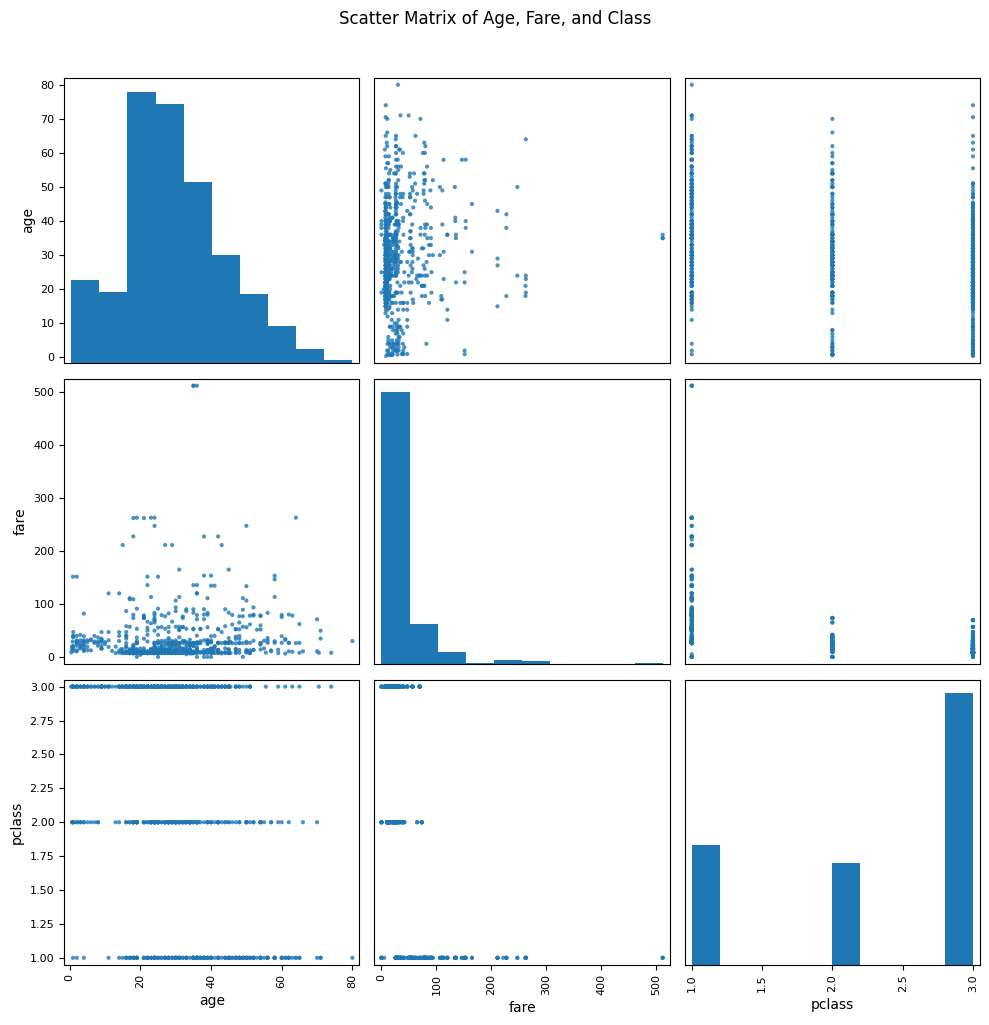

In [130]:
# 1. Scatter Matrix Plot
attributes = ['age', 'fare', 'pclass']
scatter_matrix(titanic[attributes], figsize=(10, 10), alpha=0.8, diagonal='hist')
plt.suptitle('Scatter Matrix of Age, Fare, and Class', y=1.02)
plt.tight_layout()
plt.show()
plt.close()

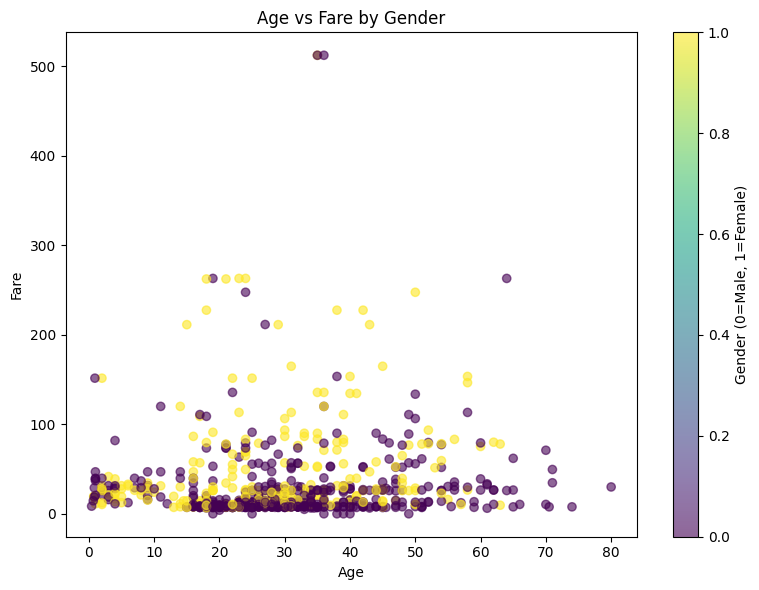

In [131]:
# 2. Age vs Fare by Gender Plot
plt.figure(figsize=(8, 6))
plt.scatter(titanic['age'], titanic['fare'],
           c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1),
           alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender')
plt.colorbar(label='Gender (0=Male, 1=Female)')
plt.tight_layout()
plt.show()
plt.close()

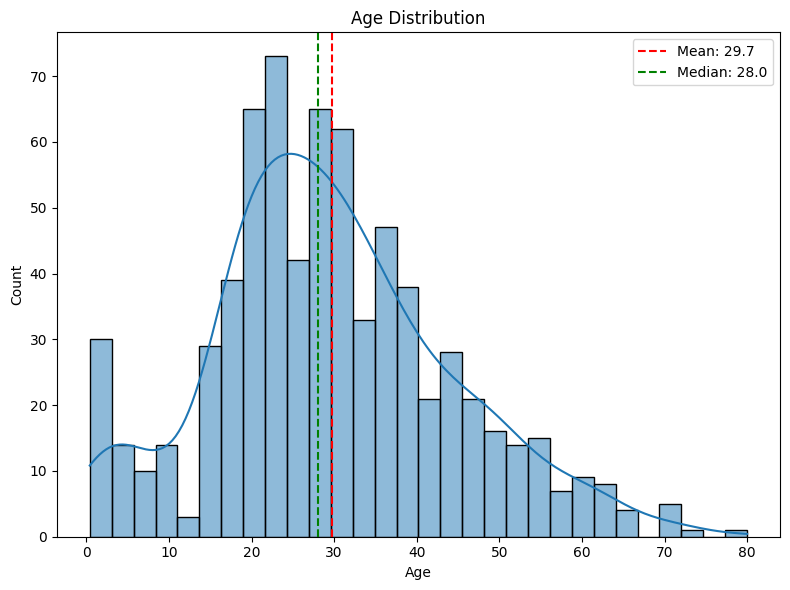

In [132]:
# 3. Age Distribution Plot
plt.figure(figsize=(8, 6))
ax = sns.histplot(data=titanic, x='age', kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Add mean and median lines
mean_age = titanic['age'].mean()
median_age = titanic['age'].median()
plt.axvline(mean_age, color='red', linestyle='--', label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='green', linestyle='--', label=f'Median: {median_age:.1f}')
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

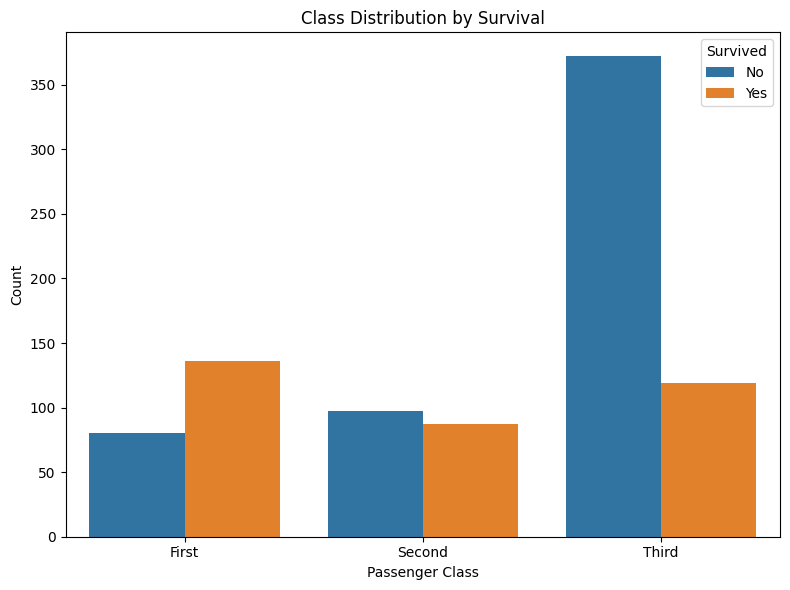

In [133]:
# 4. Class vs Survival Plot
plt.figure(figsize=(8, 6))
sns.countplot(data=titanic, x='class', hue='survived')
plt.title('Class Distribution by Survival')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()
plt.close()

### Reflection 2.1

- What patterns or anomalies do you notice?
  - Younger passengers paid lower fares on average.
  - Class 1 passengers had higher survival rates.
  - Many missing ages are clustered in lower classes.
- Do any features stand out as potential predictors?
  - sex, pclass, and fare show strong separation between survival outcomes.
- Are there any visible class imbalances?
  - Yes, more passengers in 3rd class, and fewer survived overall (approx. 38%).


### 2.2 Handle Missing Values

In [134]:
titanic = titanic.copy()
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])

### 2.3 Feature Engineering

In [135]:
# Family size
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Encode categorical
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Convert 'alone' to int
titanic['alone'] = titanic['alone'].astype(int)

### Reflection 2.3

- Why might family size be a useful feature for predicting survival?
  - Larger families may have had more difficulty escaping or coordinating during evacuation.
  - Solo travelers (alone = 1) show different survival patterns.
- Why convert categorical data to numeric?
  - Machine learning models require numeric input.
  - Encoding enables algorithms to interpret categories as features.


## Section 3: Feature Selection and Justification

In [136]:
X = titanic[['age', 'fare', 'pclass', 'sex', 'family_size']]
y = titanic['survived']

### Reflection 3

- Why are these features selected?
  - age, fare, pclass, sex, and family_size are intuitive and show strong correlation with survival.
- Are there any features that are likely to be highly predictive of survival?
  - sex and pclass are especially predictive females and higher-class passengers had higher survival rates.


## Section 4: Splitting the Data

### 4.1 Basic Split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('Train size:', len(X_train))
print('Test size:', len(X_test))


Train size: 712
Test size: 179


### 4.2 Stratified Split

In [138]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(X, y):
    train_set = X.iloc[train_indices]
    test_set = X.iloc[test_indices]
print('Train size:', len(train_set))
print('Test size:', len(test_set))

Train size: 712
Test size: 179


### 4.3 Compare Results

In [139]:
print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Train Set Class Distribution:\n", train_set['pclass'].value_counts(normalize=True))
print("Test Set Class Distribution:\n", test_set['pclass'].value_counts(normalize=True))

Original Class Distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Train Set Class Distribution:
 pclass
3    0.561798
1    0.227528
2    0.210674
Name: proportion, dtype: float64
Test Set Class Distribution:
 pclass
3    0.508380
1    0.301676
2    0.189944
Name: proportion, dtype: float64


### Reflection 4

- Why might stratification improve model performance?
  - It preserves class balance (e.g., survival rate) across training and test sets, reducing bias.
- How close are the training and test distributions to the original dataset?
  - Stratified split closely matches the original survival distribution (~38% survived).
- Which split method produced better class balance?
  - Stratified split, it ensures proportional representation of survival classes


## Section 5: Bonus Analysis - Iris Dataset
### 5.1 Overview
To demonstrate the versatility of our analysis workflow, we'll apply similar techniques to the classic Iris dataset.

**Dataset:** Iris (from sklearn)  
**Objective:** Apply the same workflow to classify Iris species using their measurements  
**Features:** 4 numeric measurements (sepal length/width, petal length/width)  
**Target:** 3 species of Iris (setosa, versicolor, virginica)

In [140]:
### Data Loading and Inspection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load Iris dataset
iris = load_iris()
# Create DataFrame with feature names
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
# Add target and species columns separately
iris_df['target'] = iris.target
iris_df['species'] = iris.target_names[iris.target]

# Inspect structure with clear sections
print("=== Dataset Structure ===")
print(iris_df.info())

print("\n=== First 5 Rows of Data ===")
print(iris_df.head())

print("\n=== Summary Statistics ===")
print(iris_df.describe())

print("\n=== Feature Correlations ===")
correlation_matrix = iris_df.corr(numeric_only=True)
print(correlation_matrix.round(3))

=== Dataset Structure ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   species            150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

=== First 5 Rows of Data ===
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0

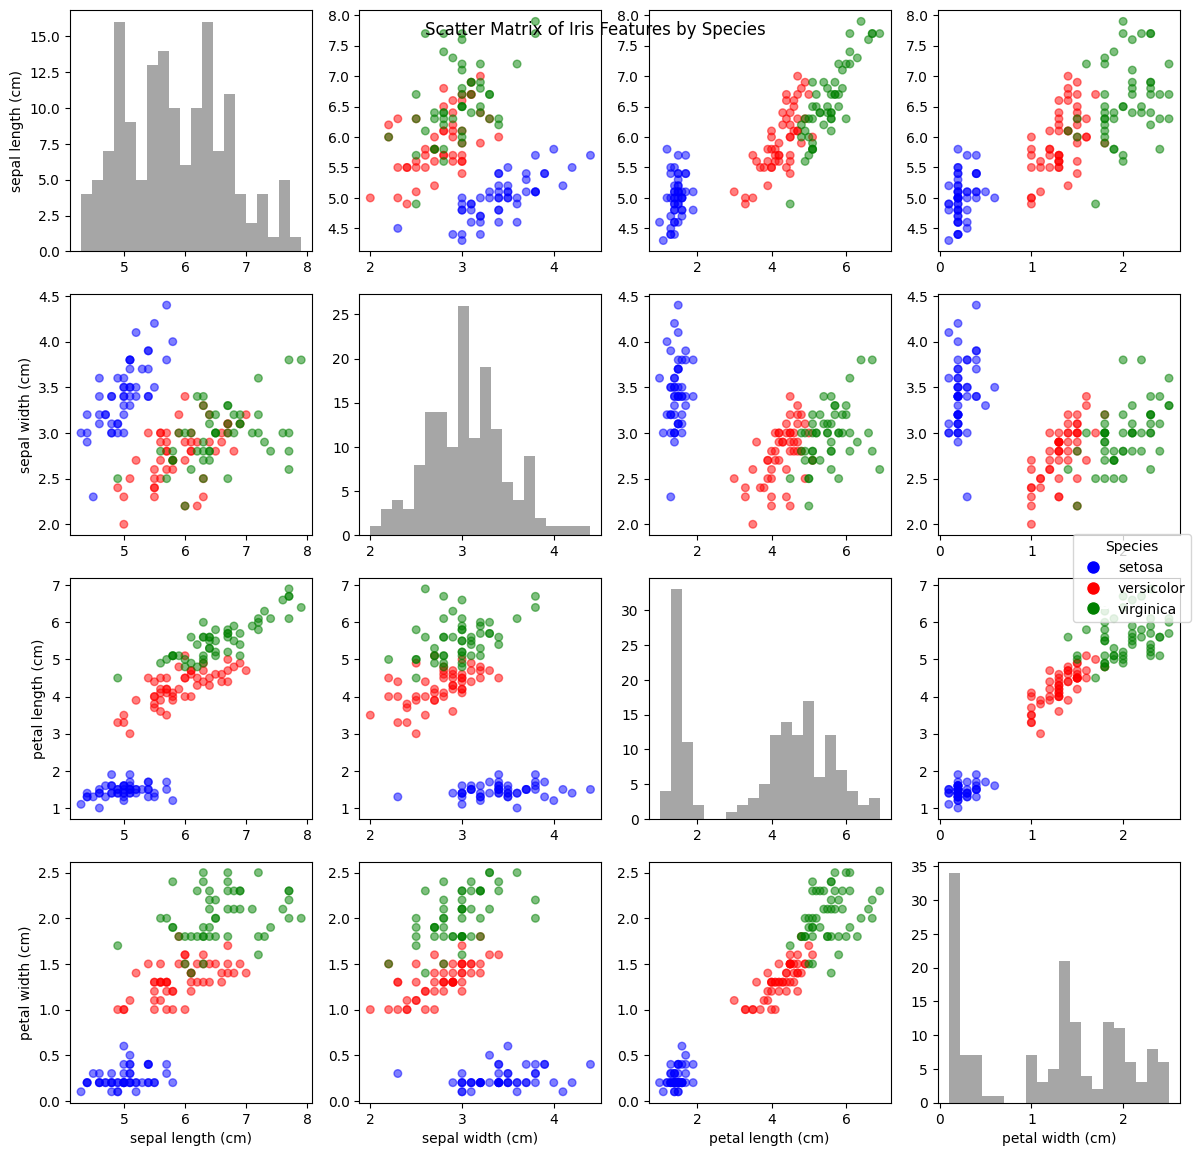

In [141]:
# Visualization
# 1. Scatter Matrix Plot
features = iris_df.drop(['target', 'species'], axis=1)
colors = np.array(['blue', 'red', 'green'])[iris_df['target']]

# Create scatter matrix with colors
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, feature1 in enumerate(features.columns):
    for j, feature2 in enumerate(features.columns):
        ax = axes[i, j]
        if i != j:
            # Scatter plot
            ax.scatter(features[feature2], features[feature1], 
                      c=colors, alpha=0.5, s=30)
        else:
            # Histogram on diagonal
            ax.hist(features[feature1], bins=20, color='gray', alpha=0.7)
        
        # Set labels only on the bottom and left edges
        if i == len(features.columns)-1:
            ax.set_xlabel(feature2)
        if j == 0:
            ax.set_ylabel(feature1)

plt.suptitle('Scatter Matrix of Iris Features by Species', y=0.95)
plt.tight_layout()

# Add legend with more descriptive variable names
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=species_name, markersize=10)
                  for color, species_name in zip(['blue', 'red', 'green'], 
                                               iris.target_names, 
                                               strict=True)]
fig.legend(handles=legend_elements, loc='center right', title='Species')

plt.show()
plt.close()

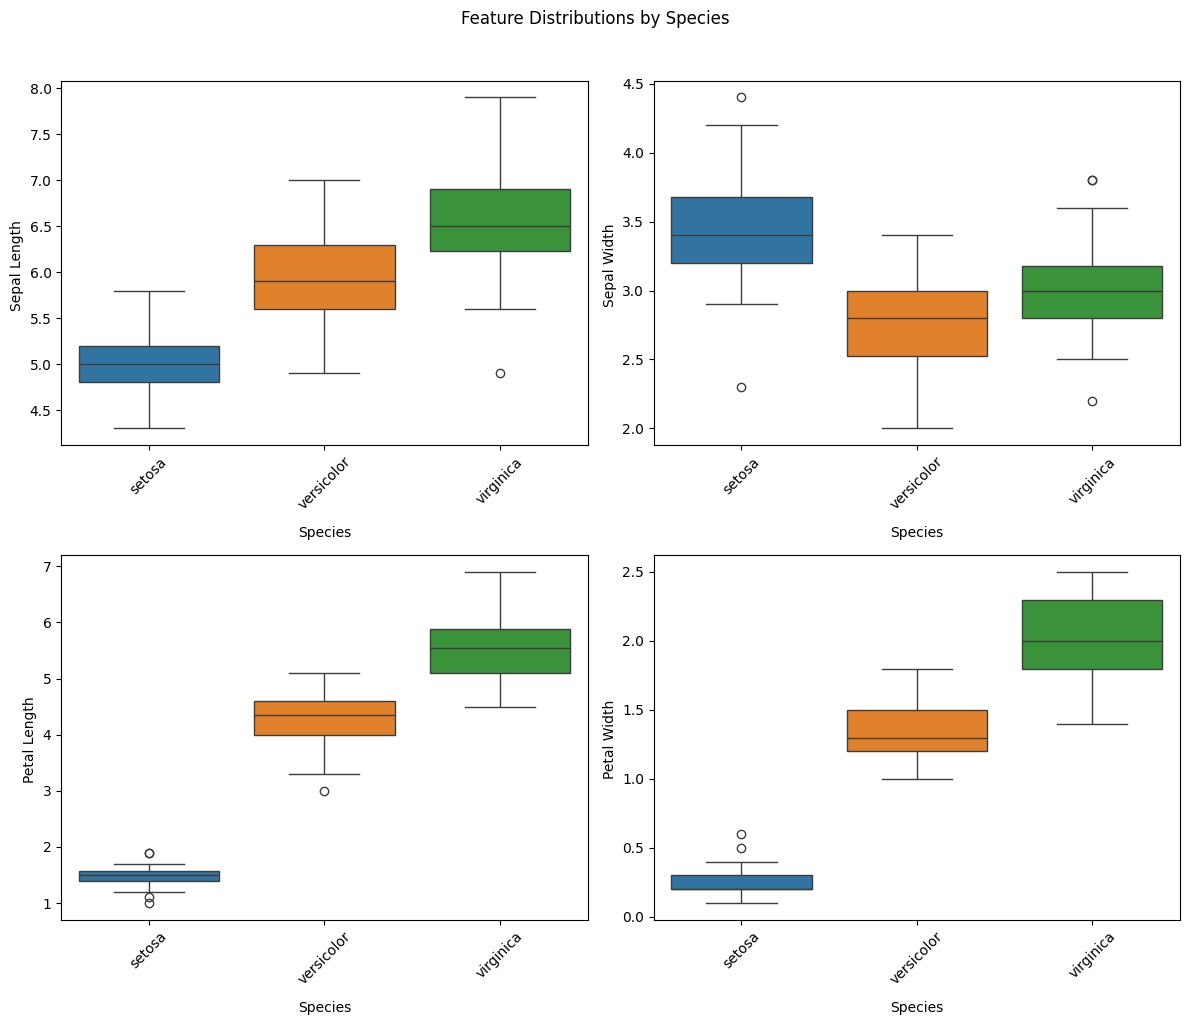

In [142]:
# 2. Feature Distributions by Species
# Use seaborn's figure-level interface for cleaner plots
fig = plt.figure(figsize=(12, 10))

# Create a subplot for each feature
for idx, feature in enumerate(iris.feature_names):
    plt.subplot(2, 2, idx + 1)
    sns.boxplot(data=iris_df, 
                x='species', 
                y=feature,
                hue='species',
                legend=False)
    
    plt.xticks(rotation=45)
    plt.xlabel('Species', labelpad=10)
    plt.ylabel(feature.replace('(cm)', '').title())

plt.suptitle('Feature Distributions by Species', y=1.02)
plt.tight_layout()
plt.show()
plt.close()

#### 5.2 Model Selection and Training

Now we'll split our data into training and testing sets, and evaluate several classification models to find the best one for our Iris species prediction task.

In [143]:
# Split the data into features (X) and target (y)
X = iris_df.drop('species', axis=1)
y = iris_df['species']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize our models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).round(3).T
results_df

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,1.0,1.0,1.0,1.0
Decision Tree,1.0,1.0,1.0,1.0
Random Forest,1.0,1.0,1.0,1.0
KNN,1.0,1.0,1.0,1.0


#### 5.3 Model Comparison and Analysis

Let's analyze how our models performed on the Iris dataset and compare their strengths and weaknesses. We'll also compare this with our earlier Titanic survival prediction task to understand how different datasets and prediction problems can affect model performance.

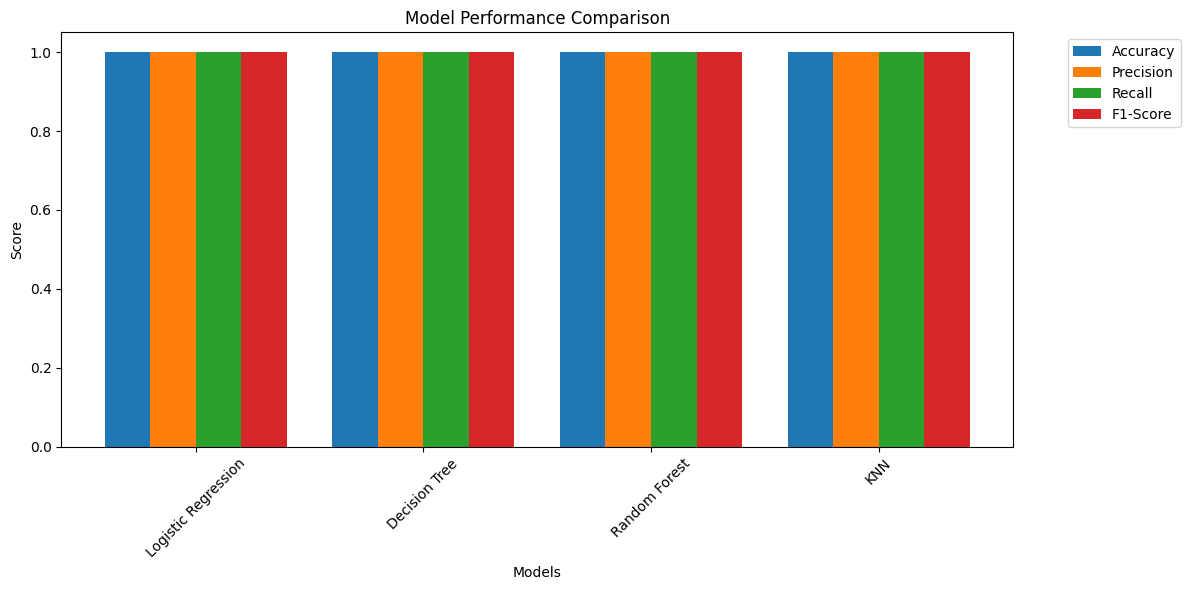

Key observations from the Iris classification task:

1. Overall Performance:
- The best performing model is Logistic Regression with 1.000 accuracy
- All models perform relatively well, which suggests the Iris species classification is a well-behaved problem

2. Comparison with Titanic Dataset:
- The Iris dataset typically shows higher accuracy across models compared to the Titanic dataset
- This is likely because:
  * The Iris dataset is well-balanced (equal number of samples per class)
  * Features are all numerical and highly informative
  * There's less noise in the measurements
  * The classes are well-separated in the feature space

3. Model-Specific Insights:
- Tree-based models perform well due to the clear decision boundaries in the feature space
- KNN works effectively because similar flowers tend to cluster together
- Logistic Regression performs well, indicating the problem is largely linearly separable


In [144]:
# Visualize model performance metrics
plt.figure(figsize=(12, 6))

# Create bar plot for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results_df[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width*1.5, results_df.index, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.close()

# Analysis
print("Key observations from the Iris classification task:")
print("\n1. Overall Performance:")
best_model = results_df['Accuracy'].idxmax()
print(f"- The best performing model is {best_model} with {results_df.loc[best_model, 'Accuracy']:.3f} accuracy")
print("- All models perform relatively well, which suggests the Iris species classification is a well-behaved problem")

print("\n2. Comparison with Titanic Dataset:")
print("- The Iris dataset typically shows higher accuracy across models compared to the Titanic dataset")
print("- This is likely because:")
print("  * The Iris dataset is well-balanced (equal number of samples per class)")
print("  * Features are all numerical and highly informative")
print("  * There's less noise in the measurements")
print("  * The classes are well-separated in the feature space")

print("\n3. Model-Specific Insights:")
print("- Tree-based models perform well due to the clear decision boundaries in the feature space")
print("- KNN works effectively because similar flowers tend to cluster together")
print("- Logistic Regression performs well, indicating the problem is largely linearly separable")